In [2]:
# Package imports
import numpy as np
import os
import pandas as pd
import proplot as pplt
import sys
from scipy.spatial.distance import cdist
sys.path.append('../../drifter/')
import utilities.cleaning as clean
import utilities.interpolation as interp

from importlib import reload
clean = reload(clean)
interp = reload(interp)

# Folder with the drift tracks from 
# the Arctic Data Center (Bliss et al. 2021)
# https://arcticdata.io/catalog/view/urn%3Auuid%3A2b859a39-cada-4147-819a-dc222f6f89a3
dataloc = '../../data/adc_dn_tracks/'
saveloc = '../data/mosaic_interpolated/'
# Maximum gap in hours for the interpolation algorithm
max_dt = 2

# Compute uncertainty threshold for splines?
recompute_thresh = False

# Pad for interpolation, so that the first and last values aren't missing.
margin = pd.to_timedelta('6H')
buoy_data = {}


# Optional: focus in on only a portion of the tracks
begin = '2019-10-01 00:00'
end = '2022-01-01 00:00'

# Read in the files, including the metadata file
metadata = pd.read_csv(dataloc + 'DN_buoy_list_v2.csv')
metadata['filename'] = ['_'.join([x, str(y), z]) for 
                        x, y, z in zip(metadata['DN Station ID'],
                                       metadata['IMEI'],
                                       metadata['Sensor ID'])]
    
file_present = np.array([f + '.csv' in files for f in metadata.filename])
metadata = metadata.loc[file_present].copy()
metadata.set_index('Sensor ID', inplace=True)

dataloc = '../data/mosaic_qc/'
files = os.listdir(dataloc)
files = [f for f in files if f.split('.')[-1] == 'csv']
files = [f for f in files if f.split('_')[0] != 'DN']


buoy_data = {}
freq = []
buoys = []
for file in files:
    data = pd.read_csv(dataloc + file, index_col='datetime', parse_dates=True)
    dt = pd.to_timedelta(np.diff(data.index)).median().seconds/3600
    buoy = file.replace('.csv', '').split('_')[-1]
    if np.round(dt,1) <= max_dt:
        buoy_data[buoy] = data.copy()
        freq.append(np.round(dt, 1))
        buoys.append(buoy)
    else:
        print(buoy, dt)
buoy_freq = pd.Series(freq, buoys)


In [3]:
dataloc = '../data/mosaic_interpolated/'
files = os.listdir(dataloc)
files = [f for f in files if f.split('.')[-1] == 'csv']
files = [f for f in files if f.split('_')[0] != 'DN']

buoy_data_interp = {}
for file in files:
    data = pd.read_csv(dataloc + file, index_col='datetime', parse_dates=True)
    
    buoy = file.replace('.csv', '').split('_')[-1]
    
    buoy_data_interp[buoy] = data.copy()
    



In [21]:
df_x = pd.DataFrame({buoy: buoy_data_interp[buoy]['x'] for buoy in buoy_data})
df_y = pd.DataFrame({buoy: buoy_data_interp[buoy]['y'] for buoy in buoy_data})

In [29]:
timeslice = slice('2019-11-01 00:00', '2019-11-15 00:00')
X = df_x.loc[timeslice].median().dropna()
Y = df_y.loc[timeslice].median().dropna()

In [108]:
X = np.array([df_x.iloc[10,:].fillna(0), df_y.iloc[10,:].fillna(0)]).T

In [109]:
from scipy.spatial import distance_matrix
dist = distance_matrix(X, X, p=2)
dist = pd.DataFrame(data=dist, columns=df_x.columns, index=df_x.columns)

In [117]:
# Just the distances between 'CO1' buoys
df_x.loc[:, site_buoys['CO1']].dropna()

,2019P161,2019F4,ASFSTUCB1
datetime,,,
2019-11-02 18:00:00,-390149.367333,-390370.791704,-390380.822923
2019-11-02 19:00:00,-390179.135919,-390396.589486,-390405.183632
2019-11-02 20:00:00,-390208.724704,-390432.006170,-390438.127077
2019-11-02 21:00:00,-390241.464981,-390462.715449,-390468.924747
2019-11-02 22:00:00,-390254.901026,-390480.104110,-390489.612283
...,...,...,...
2019-11-14 22:00:00,-375259.943324,-375417.824660,-375414.950207
2019-11-14 23:00:00,-375161.906205,-375320.705401,-375317.266421
2019-11-15 00:00:00,-375030.067177,-375190.505779,-375187.134279


In [56]:
site_buoys = {}
for name, group in metadata.loc[dist.index].groupby('DN Station ID'):
    if name[0] == 'P':
        name = 'P'
    site_buoys[name] = group.index.to_list()

In [113]:
order=list(np.hstack([list(site_buoys[x]) for x in site_buoys]))


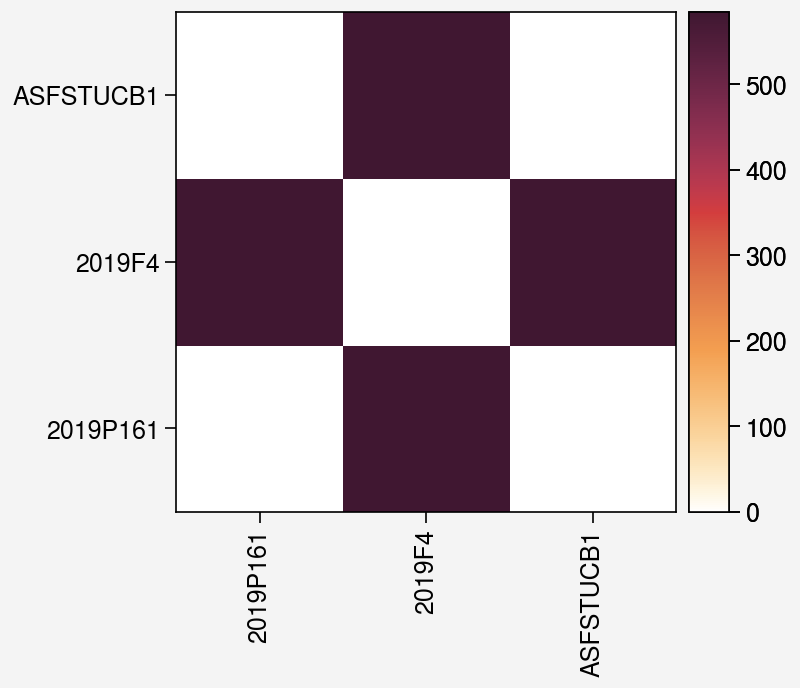

In [111]:
fig, ax = pplt.subplots(width=4)
ax.heatmap(dist.loc[site_buoys['CO1'],  site_buoys['CO1']]/1e3, colorbar='r')
ax.format(xrotation=90)

In [77]:
np.sqrt((X['2019P161'] - X['ASFSTUCB1'])**2 + (Y['2019P161'] - Y['ASFSTUCB1'])**2)

1180.5273886077703

In [78]:
dist.loc['2019P161', 'ASFSTUCB1']

191370.19578734768